# Designing a Predictive Model for Students’ Dropout and Academic Success

##### Group Members (Group 46): 
Erin Da   
Lesley Mai   
Xiaofei Sun   
Yuchen Xu   
<hr style="opacity: 0.3" />

## 1. Introduction

Dropout rates and academic success play vital roles within higher education institutions<sup>[1]</sup>, the academic success not only affects individual students but also affects society at large. Therefore, harnessing the available data to predict students’ dropout and academic success status holds significant worth.

Our [dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) originates from a higher education institution, including students enrollment information (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters<sup>[2]</sup>. Given a student with related features, we can classify the student’s academic status (enrolled, graduate or dropout).

#### Research question

We aim to **employ the K-Nearest Neighbors (KNN) classification algorithm to predict students' dropout and academic success statuses**. KNN is an intuitive algorithm that classifies new data points based on their similarity to existing data points in the feature space<sup>[3]</sup>. 

Moreover, we seek to identify the specific variables that hold the strongest influence over student dropout and academic success.

## 2. Preliminary exploratory data analysis

We load requisite packages for analysis, and read our dataset in a `.csv` file.

In [1]:
# packages
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(cowplot)
library(RcolorBrewer)
options(repr.matrix.max.rows = 12) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# load data
url <- "https://raw.githubusercontent.com/lesleymai/ds_group/main/academic_success.csv"

# use read_delim()to load our data as this dataset uses ; as a separator.
students_data <- read_delim(url, show_col_types = FALSE)

# convert column names to valid R names
colnames(students_data) <- make.names(colnames(students_data))
summary(students_data)

 Marital.status  Application.mode Application.order     Course    
 Min.   :1.000   Min.   : 1.00    Min.   :0.000     Min.   :  33  
 1st Qu.:1.000   1st Qu.: 1.00    1st Qu.:1.000     1st Qu.:9085  
 Median :1.000   Median :17.00    Median :1.000     Median :9238  
 Mean   :1.179   Mean   :18.67    Mean   :1.728     Mean   :8857  
 3rd Qu.:1.000   3rd Qu.:39.00    3rd Qu.:2.000     3rd Qu.:9556  
 Max.   :6.000   Max.   :57.00    Max.   :9.000     Max.   :9991  
 Daytime.evening.attendance. Previous.qualification
 Min.   :0.0000              Min.   : 1.000        
 1st Qu.:1.0000              1st Qu.: 1.000        
 Median :1.0000              Median : 1.000        
 Mean   :0.8908              Mean   : 4.578        
 3rd Qu.:1.0000              3rd Qu.: 1.000        
 Max.   :1.0000              Max.   :43.000        
 Previous.qualification..grade.  Nacionality      Mother.s.qualification
 Min.   : 95.0                  Min.   :  1.000   Min.   : 1.00         
 1st Qu.:125.0       

<left><em>Table 1: Raw students' performance Dataset</em></left>

In [3]:
# count the number of rows containing at least one NA
num_na_rows <- sum(apply(is.na(students_data), 1, any))
print(num_na_rows)
# we can see that there're no NA rows in the dataset

[1] 0


In addition, we focus on predicting if a student achieves academic success by classifying him or her as a graduated student or a dropout, so we filter out the enrolled students in our dataset.

In [4]:
students_data_filtered <-  students_data |>
    filter(Target != "Enrolled") |>
    mutate(Target = as.factor(Target)) 


students_data_filtered

Marital.status,Application.mode,Application.order,Course,Daytime.evening.attendance.,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,Father.s.qualification,⋯,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.66667,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.40000,0,9.4,-0.8,-3.12,Graduate
2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.00000,0,13.9,-0.3,0.79,Graduate
2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.50000,5,16.2,0.3,-0.92,Graduate
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,44,1,9070,1,39,120,1,3,38,⋯,5,9,10,7,13.14286,1,16.2,0.3,-0.92,Graduate
1,1,6,9773,1,1,125,1,1,1,⋯,0,6,8,5,12.66667,0,15.5,2.8,-4.06,Graduate


## 3. Methods & Results

We split dataset into a `training set` and a `test set` for further analysis and model evaluation. This ensures that our model's performance is assessed on unseen data, simulating real-world applications.

In [5]:
set.seed(2023) 
# Using a 75/25 split and stratifying on the target variable to ensure the sets have similar proportions of each class
students_split <- initial_split(students_data_filtered, prop = 0.75, strata = Target)

# Extract the training and testing data from the split
students_train <- training(students_split)
students_test <- testing(students_split) 

The whole table contains 37 explanatory variables, we select relevant variables that we hypothesized would have significant influence over academic success and dropout rates to build the classifier.

In [6]:
students_numerical_data <- students_train |>
      select(-Daytime.evening.attendance., 
-Displaced, 
-Debtor, 
-Scholarship.holder,
-Tuition.fees.up.to.date,
-Educational.special.needs,
-Gender,
-International)

head(students_numerical_data)

students_binary_data<- students_train |>
select(Daytime.evening.attendance., 
Displaced, 
Debtor, 
Scholarship.holder,
Tuition.fees.up.to.date,
Educational.special.needs,
Gender,
International,
Target)

head(students_binary_data)

Marital.status,Application.mode,Application.order,Course,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,Father.s.qualification,Mother.s.occupation,⋯,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,17,5,171,1,122.0,1,19,12,5,⋯,0,0,0,0,0,0,10.8,1.4,1.74,Dropout
1,1,5,9070,1,122.0,1,37,37,9,⋯,0,6,0,0,0,0,10.8,1.4,1.74,Dropout
1,1,2,9853,1,133.0,1,19,37,4,⋯,0,6,0,0,0,0,12.7,3.7,-1.70,Dropout
1,39,1,33,1,130.0,1,38,37,9,⋯,0,7,7,1,10,0,8.9,1.4,3.51,Dropout
1,39,1,9119,10,133.1,1,34,37,0,⋯,0,5,0,0,0,0,7.6,2.6,0.32,Dropout
1,43,1,9147,1,140.0,1,37,37,6,⋯,0,5,8,2,12,2,16.2,0.3,-0.92,Dropout


Daytime.evening.attendance.,Displaced,Debtor,Scholarship.holder,Tuition.fees.up.to.date,Educational.special.needs,Gender,International,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,0,0,1,0,1,0,Dropout
1,1,0,0,0,0,1,0,Dropout
1,1,0,0,1,0,0,0,Dropout
1,0,1,0,0,0,1,0,Dropout
1,1,0,0,1,0,1,0,Dropout
1,0,0,0,1,0,0,0,Dropout


factors,0,1,diff,status
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Educational.special.needs,0.9877934,0.01220657,-0.9755869,Dropout
International,0.9765258,0.02347418,-0.9530516,Dropout
Scholarship.holder,0.9117371,0.08826291,-0.8234742,Dropout
Daytime.evening.attendance.,0.1352113,0.86478873,0.7295775,Dropout
Debtor,0.7718310,0.22816901,-0.5436620,Dropout
Tuition.fees.up.to.date,0.3258216,0.67417840,0.3483568,Dropout
⋮,⋮,⋮,⋮,⋮
International,0.97705314,0.02294686,-0.9541063,Graduate
Debtor,0.95591787,0.04408213,-0.9118357,Graduate


factors,difference
<chr>,<dbl>
Educational.special.needs,0.011128121
International,0.001054637
Scholarship.holder,0.573474178
Daytime.evening.attendance.,0.100132680
Debtor,0.368173777
Tuition.fees.up.to.date,0.625073144
Displaced,0.274396135
Gender,0.496380214


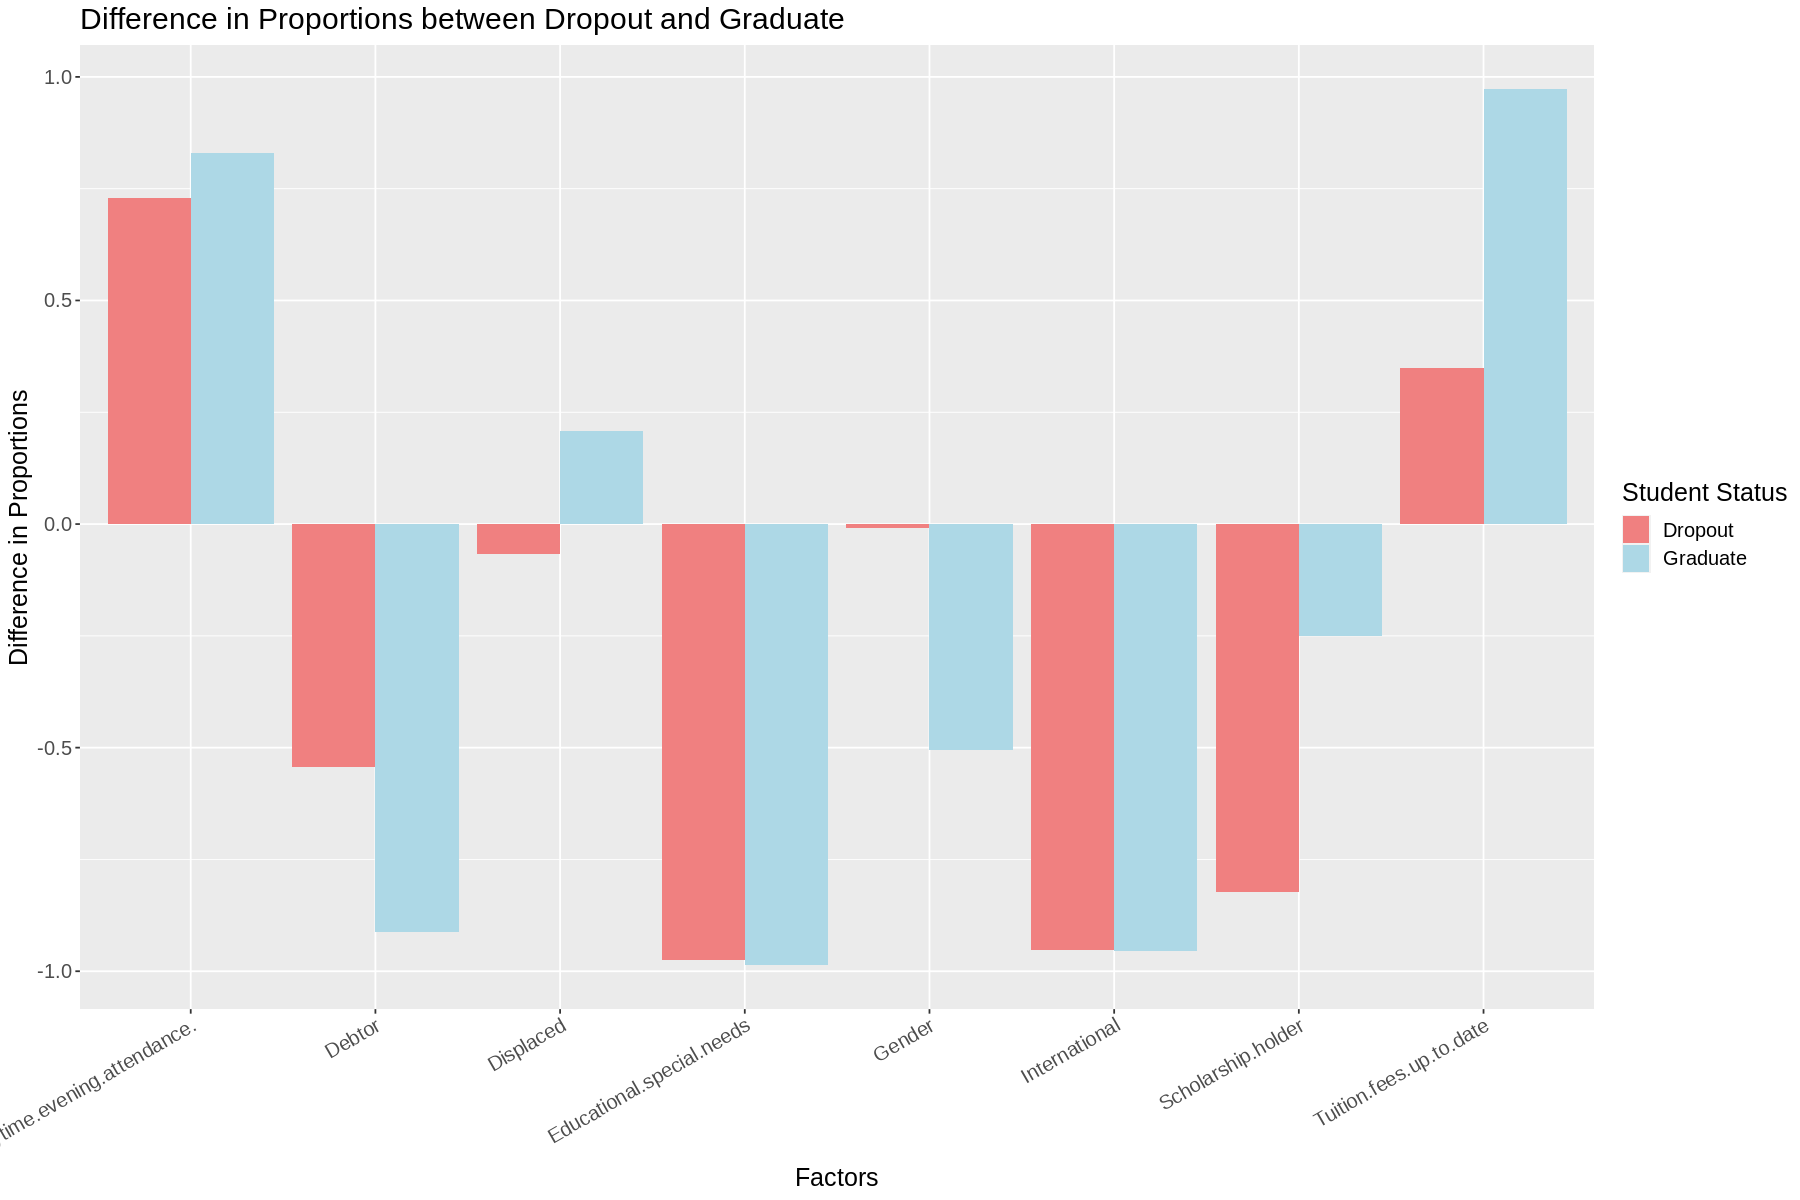

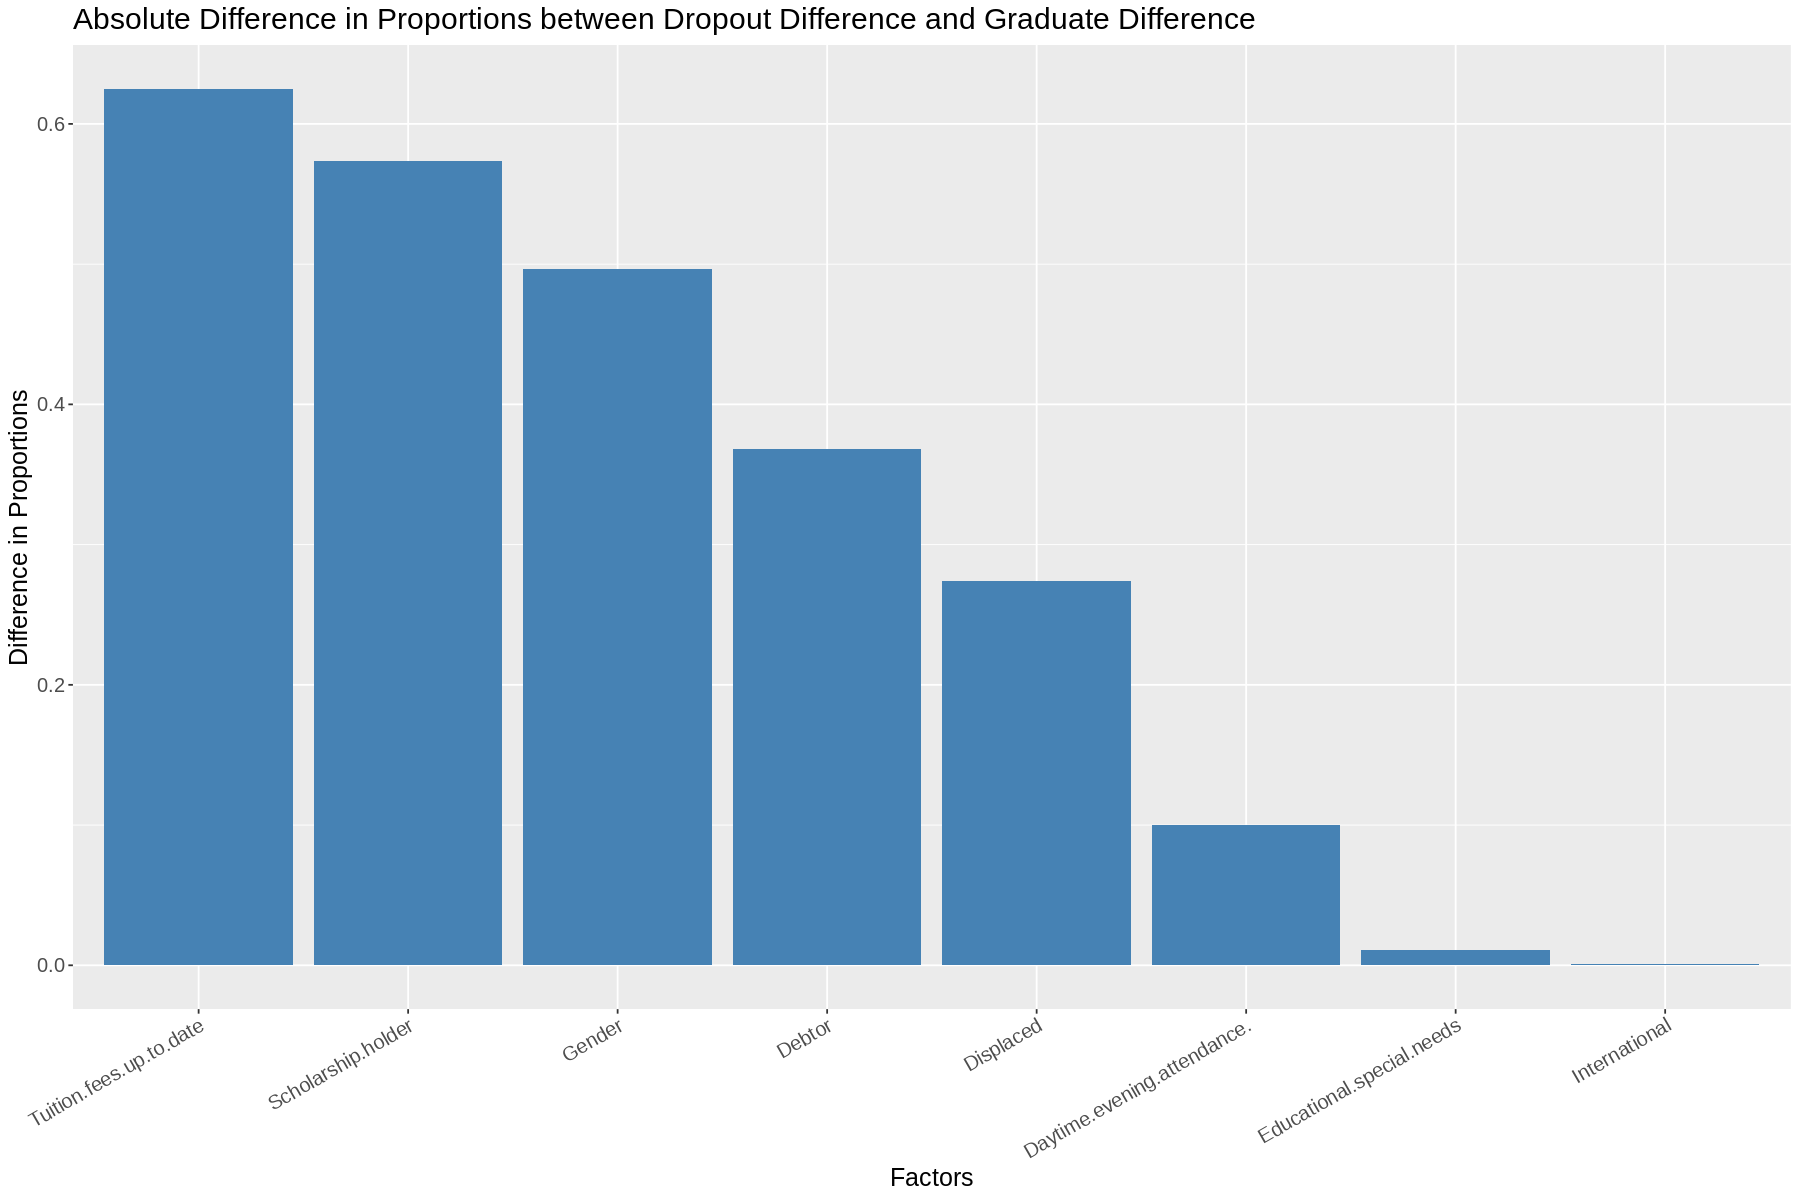

In [7]:
dropout_total <- students_train |>
filter(Target == "Dropout") |>
count(Target)|> 
pull(n)                      

graduate_total <-  students_train |>
filter(Target == "Graduate") |>
count(Target)|>
pull(n)

drop_performance_factor <- students_binary_data |> 
    filter(Target=="Dropout")|>
    pivot_longer(cols=Daytime.evening.attendance.: International,
        names_to="factors",
        values_to= "factors_value")|>
    group_by(factors, factors_value) |>
    summarize(prop=n()/dropout_total, .groups = "drop_last")|>
    arrange(desc(prop))

dropout_diff <- drop_performance_factor |>
        pivot_wider(names_from = factors_value, values_from = prop) |>
        mutate(diff = `1` - `0`)

grad_performance_factor <- students_binary_data |> 
    filter(Target=="Graduate")|>
    pivot_longer(cols=Daytime.evening.attendance.: International,
        names_to="factors",
        values_to= "factors_value")|>
    group_by(factors, factors_value) |>
    summarize(prop=n()/graduate_total, .groups = "drop_last")|>
    arrange(desc(prop))

graduate_diff <- grad_performance_factor |>
        pivot_wider(names_from = factors_value, values_from = prop) |>
        mutate(diff = `1` - `0`)

# visualization
options(repr.plot.width=15, repr.plot.height=10)

dropout_diff$status <- "Dropout"
graduate_diff$status <- "Graduate"

combined_diff <- bind_rows(dropout_diff, graduate_diff)
combined_diff
final_diff <- dropout_diff |>
  inner_join(graduate_diff, by = "factors") |>
  mutate(difference = diff.x - diff.y) |>
  select(factors, difference)

final_diff_abs<- final_diff |>
    mutate_at(vars(difference), abs)
final_diff_abs

plotting <- ggplot(combined_diff, aes(x = factors, y = diff, fill = status)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
  labs(x = "Factors", y = "Difference in Proportions", 
       title = "Difference in Proportions between Dropout and Graduate", 
       fill = "Student Status") +
  scale_fill_manual(values = c("Dropout" = "lightcoral", "Graduate" = "lightblue")) +
  theme(text = element_text(size = 15))
plotting

diff_plot <- ggplot(final_diff_abs, aes(x = reorder(factors, -difference), y = difference)) +
  geom_bar(stat = "identity", position = position_dodge(), fill = "steelblue") +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
  labs(x = "Factors", y = "Difference in Proportions", 
       title = "Absolute Difference in Proportions between Dropout Difference and Graduate Difference") +
  theme(text = element_text(size = 15))
diff_plot

In [8]:
Marital_dis <- ggplot(students_numerical_data, aes(x = Marital.status, fill = Target)) +
    geom_histogram(binwidth = 0.5) +
    facet_grid(cols = vars(Target)) +
    labs(x = "Marital status", fill = "Study Status") +
    theme(text = element_text(size = 10))

AppMode_dis <- ggplot(students_numerical_data, aes(x = Application.mode, fill = Target)) +
    geom_histogram(binwidth = 5) +
    facet_grid(cols = vars(Target)) +
    labs(x = "Application mode", fill = "Study Status") +
    theme(text = element_text(size = 10))

AppOrder_dis <- ggplot(students_numerical_data, aes(x = Application.order, fill = Target)) +
    geom_histogram(binwidth = 1) +
    facet_grid(cols = vars(Target)) +
    labs(x = "Application order", fill = "Study Status") +
    theme(text = element_text(size = 10))

Course_dis<- ggplot(students_numerical_data, aes(x=Course, fill=Target))+
    geom_histogram(binwidth = 1000)+
    facet_grid(cols= vars(Target))+
    labs(x="Course",fill="study status")+
    theme(text=element_text(size=10))

PrevQual_dis<- ggplot(students_numerical_data, aes (x=Previous.qualification, fill=Target))+
    geom_histogram(binwidth = 5)+
    facet_grid(cols= vars(Target))+
    labs(x="Previous qualification",fill="study status")+
    theme(text=element_text(size=10))

PrevQualGrade_dis <- ggplot(students_numerical_data, aes(x = Previous.qualification..grade., fill = Target)) +
    geom_histogram(binwidth = 7) +
    facet_grid(cols = vars(Target)) +
    labs(x = "Previous qualification (grade)", fill = "Study Status") +
    theme(text = element_text(size = 10))

Nationality_dis<- students_numerical_data|>
    ggplot(aes(x=Nacionality, fill=Target))+
    geom_histogram(binwidth = 10) +
    facet_grid(cols= vars(Target))+
    labs(x="Nacionality",fill="study status")+
    theme(text=element_text(size=10))

MotherQual_dis<-students_numerical_data|>
    ggplot(aes(x=Mother.s.qualification , fill=Target))+
    geom_histogram(binwidth = 5)+
    facet_grid(cols= vars(Target))+
    labs(x="Mother’s qualification",fill="study status")+
    theme(text=element_text(size=10))

FatherQual_dis<-students_numerical_data|>
    ggplot(aes(x=Father.s.qualification , fill=Target))+
    geom_histogram(binwidth = 5)+
    facet_grid(cols= vars(Target))+
    labs(x="Father’s qualification",fill="study status")+
    theme(text=element_text(size=10))

MotherOccu_dis<-students_numerical_data|>
    ggplot(aes(x= Mother.s.occupation, fill=Target))+
    geom_histogram(binwidth = 13)+
    facet_grid(cols= vars(Target))+
    labs(x="Mother’s occupation",fill="study status")+
    theme(text=element_text(size=10))

FatherOccu_dis<-students_numerical_data|>
    ggplot(aes(x= Father.s.occupation, fill=Target))+
    geom_histogram(binwidth = 13)+
    facet_grid(cols= vars(Target))+
    labs(x="Mother’s occupation",fill="study status")+
    theme(text=element_text(size=10))

AdmissionGrade_dis<-students_numerical_data|>
    ggplot(aes(x=Admission.grade , fill=Target))+
    geom_histogram(binwidth = 7)+
    facet_grid(cols= vars(Target))+
    labs(x="Admission grade",fill="study status")+
    theme(text=element_text(size=10))

AgeEnroll_dis<-students_numerical_data|>
    ggplot(aes(x=Age.at.enrollment , fill=Target))+
    geom_histogram(binwidth = 5)+
    facet_grid(cols= vars(Target))+
    labs(x="Age at enrollment",fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemCrd_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..credited., fill=Target))+
    geom_histogram(binwidth = 3)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the 1st semester(credited)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemEnr_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..enrolled., fill=Target))+
    geom_histogram(binwidth = 3)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the 1st semester(erolled)", fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemEvalu_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..evaluations., fill=Target))+
    geom_histogram(binwidth = 4)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the first semester (evaluation)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemAppr_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..approved., fill=Target))+
    geom_histogram(binwidth = 3)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the 1st semester (approved)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemGrade_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..grade., fill=Target))+
    geom_histogram(binwidth = 2)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the 1st semester (grade)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit1SemNoEval_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.1st.sem..without.evaluations., fill=Target))+
    geom_histogram(binwidth = 1)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units in the 1st semester (without evaluations)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemCrd_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..credited., fill=Target))+
    geom_histogram(binwidth = 2)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem(credited)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemEnr_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..enrolled., fill=Target))+
    geom_histogram(binwidth = 3)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem (enrolled)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemNoEval_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..without.evaluations., fill=Target))+
    geom_histogram(binwidth = 2)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem (without evaluations)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemEvalu_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..evaluations., fill=Target))+
    geom_histogram(binwidth = 3)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem ( evaluations)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemAppr_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..approved., fill=Target))+
    geom_histogram(binwidth = 2)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem (approved)",fill="study status")+
    theme(text=element_text(size=10))

CurUnit2SemGrade_dis<-students_numerical_data|>
    ggplot(aes(x=Curricular.units.2nd.sem..grade., fill=Target))+
    geom_histogram(binwidth = 2)+
    facet_grid(cols= vars(Target))+
    labs(x="Curricular units 2nd.sem (grade)",fill="study status")+
    theme(text=element_text(size=10))

UnempRate_dis<-students_numerical_data|>
    ggplot(aes(x=Unemployment.rate, fill=Target))+
    geom_histogram(binwidth = 0.7)+
    facet_grid(cols= vars(Target))+
    labs(x="Unemployment rate",fill="study status")+
    theme(text=element_text(size=10))

InflaRate_dis<-students_numerical_data|>
    ggplot(aes(x=Inflation.rate, fill=Target))+
    geom_histogram(binwidth = 0.5)+
    facet_grid(cols= vars(Target))+
    labs(x="Inflation rate",fill="study status")+
    theme(text=element_text(size=10))

GDP_dis<-students_numerical_data|>
    ggplot(aes(x=GDP, fill=Target))+
    geom_histogram(binwidth = 0.7)+
    facet_grid(cols= vars(Target))+
    labs(x="GDP",fill="study status")+
    theme(text=element_text(size=10))

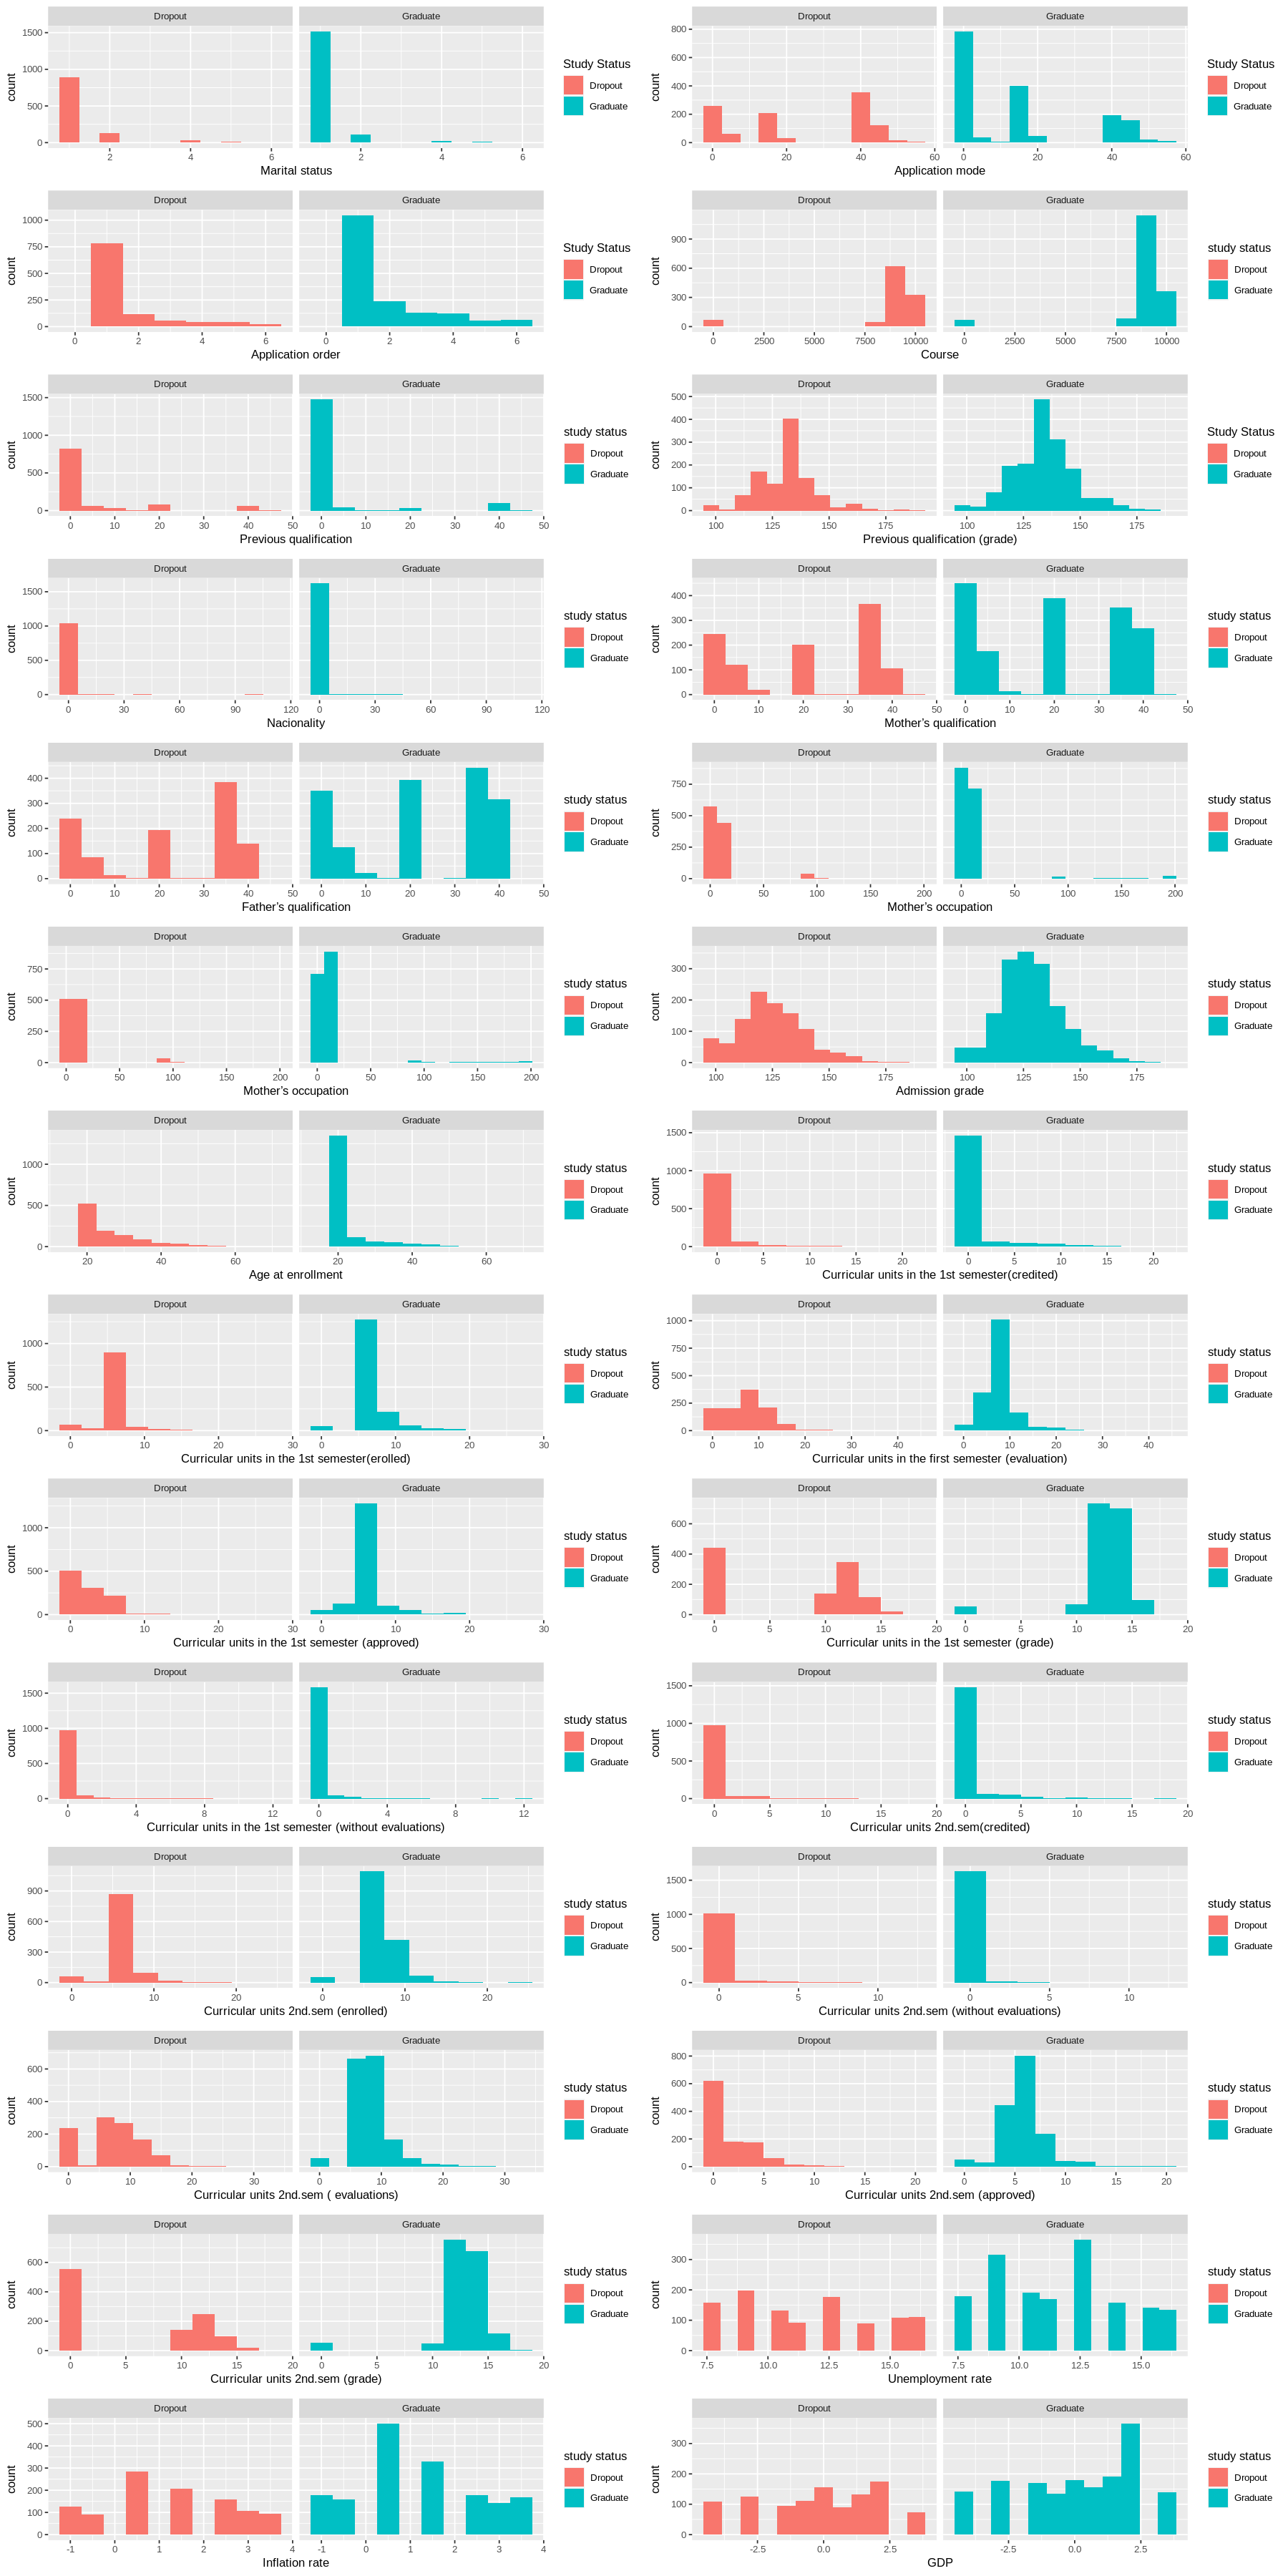

In [9]:
options(repr.plot.width = 15, repr.plot.height = 30)

plot_grid(Marital_dis, AppMode_dis, AppOrder_dis, Course_dis, PrevQual_dis, 
          PrevQualGrade_dis, Nationality_dis, MotherQual_dis, FatherQual_dis,  
          MotherOccu_dis, FatherOccu_dis, AdmissionGrade_dis, AgeEnroll_dis,
          CurUnit1SemCrd_dis, CurUnit1SemEnr_dis, CurUnit1SemEvalu_dis, 
          CurUnit1SemAppr_dis, CurUnit1SemGrade_dis, CurUnit1SemNoEval_dis,
          CurUnit2SemCrd_dis, CurUnit2SemEnr_dis, CurUnit2SemNoEval_dis,  
          CurUnit2SemEvalu_dis, CurUnit2SemAppr_dis, CurUnit2SemGrade_dis,
          UnempRate_dis, InflaRate_dis, GDP_dis, 
        align = "v",ncol = 2) 

## Classification


In [16]:
# set.seed(2023)
students_subset <- students_train |>
    select(Target, Curricular.units.2nd.sem..grade., Curricular.units.2nd.sem..approved., Tuition.fees.up.to.date,
           Curricular.units.1st.sem..approved., Debtor, Scholarship.holder, Curricular.units.1st.sem..evaluations.,
           Curricular.units.2nd.sem..evaluations., Gender, Curricular.units.1st.sem..grade., Application.mode, Admission.grade)
names <- colnames(students_subset |> select(-Target))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

students_vfold <- vfold_cv(students_subset, v = 5, strata = Target)

n_total <- length(names)

selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Target", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        students_recipe <- recipe(as.formula(model_string), 
                                data = students_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(students_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = students_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

| size | model_string                          |    accuracy |
|--------|---------------------------------------------|------|
| 1     | Target ~ Curricular.units.2nd.sem..grade.  | 0.7717856  |
| 2     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. | 0.8702746  |
|  3   | Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date   |  0.8915853 |
| 4     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. | 0.8974676 |
| 5     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor |0.8982009 |
| 6     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor + Scholarship.holder|0.8985672 |
|  7   | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor + Scholarship.holder + Curricular.units.1st.sem..evaluations.| 0.9033473 |
| 8     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor + Scholarship.holder + Curricular.units.1st.sem..evaluations. + Curricular.units.2nd.sem..evaluations.| 0.9055498|
| 9     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor + Scholarship.holder + Curricular.units.1st.sem..evaluations. + Curricular.units.2nd.sem..evaluations. + Gender | 0.9073860 |
| 10     | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor+Scholarship.holder + Curricular.units.1st.sem..evaluations. + Curricular.units.2nd.sem..evaluations. + Gender+Curricular.units.1st.sem..grade.  | 0.9070177 |
|  11   | arget ~  Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date+Curricular.units.1st.sem..approved.+Debtor + Scholarship.holder + Curricular.units.1st.sem..evaluations. + Curricular.units.2nd.sem..evaluations. + Gender+Curricular.units.1st.sem..grade. + Application.mode  | 0.9022410  |
| 12    | Target ~ Curricular.units.2nd.sem..grade. + Curricular.units.2nd.sem..approved. + Tuition.fees.up.to.date + Curricular.units.1st.sem..approved. + Debtor+Scholarship.holder + Curricular.units.1st.sem..evaluations. + Curricular.units.2nd.sem..evaluations. + Gender + Curricular.units.1st.sem..grade. + Application.mode+Admission.grade |0.8945224|

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


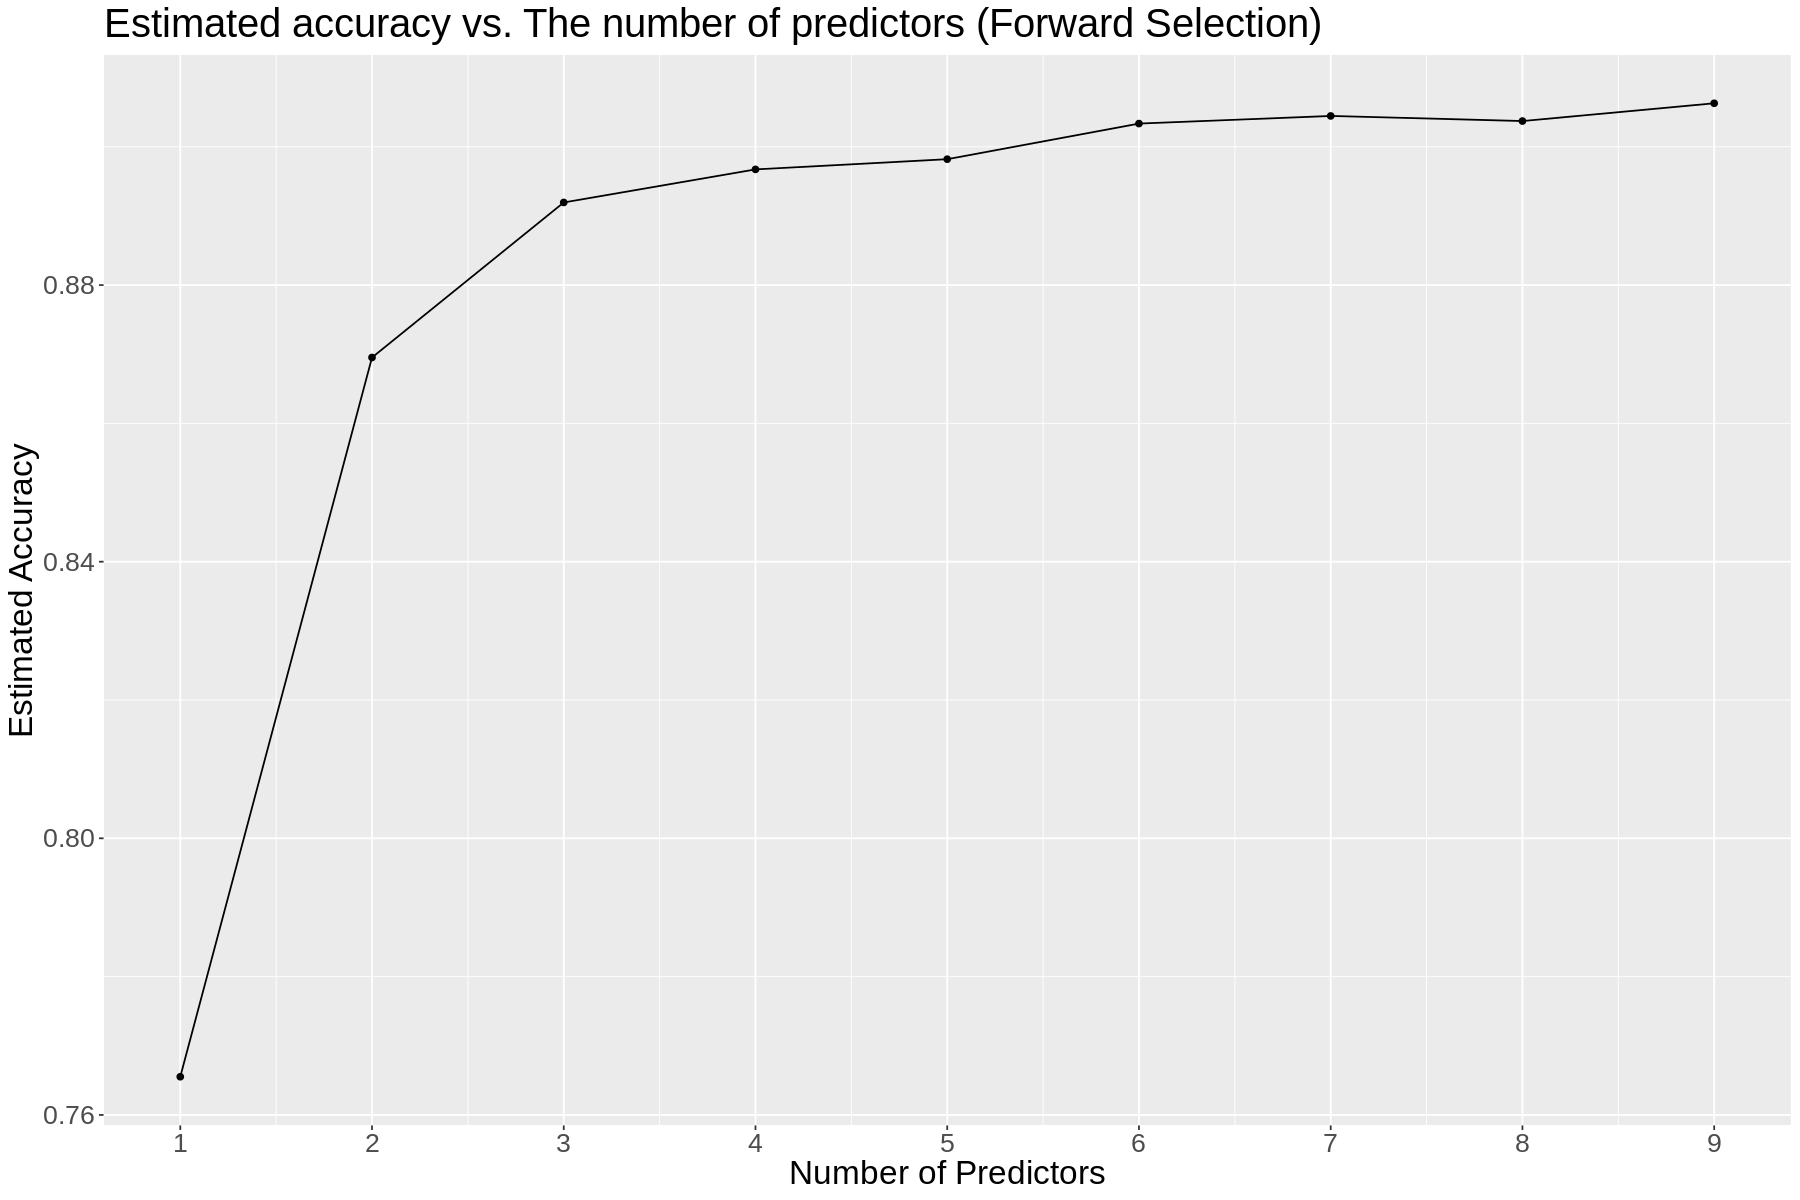

In [11]:
# Plotting estimated accuracy vs the number of predictors
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_point() + # To show each point
    geom_line() +  # To connect points with lines
    labs(x = "Number of Predictors", y = "Estimated Accuracy") +
    ggtitle("Estimated accuracy vs. The number of predictors (Forward Selection)") +
    scale_x_continuous(limits = c(1,9), breaks = seq(1, 19)) +
    theme(text = element_text(size = 20)) 


In [12]:
set.seed(2023) 

students_recipe <- recipe(Target ~ Tuition.fees.up.to.date + Scholarship.holder + Debtor + Curricular.units.1st.sem..approved. + Curricular.units.2nd.sem..approved. + Curricular.units.2nd.sem..grade. + Application.mode, data = students_train) |>
    step_scale(all_predictors()) |>
    step_scale(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

students_vfold <- vfold_cv(students_train, v = 10 , strata= Target) 

gridvals <- tibble(neighbors = seq(1,25))

students_results <- workflow() |>
    add_recipe(students_recipe) |>
    add_model(knn_spec)|>
    tune_grid(resamples = students_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "accuracy")
students_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8563199,10,0.005397355,Preprocessor1_Model01
2,accuracy,binary,0.8548533,10,0.005241931,Preprocessor1_Model02
3,accuracy,binary,0.8787331,10,0.009096629,Preprocessor1_Model03
4,accuracy,binary,0.8794711,10,0.008954593,Preprocessor1_Model04
5,accuracy,binary,0.8963885,10,0.007528177,Preprocessor1_Model05
6,accuracy,binary,0.8963885,10,0.007528177,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
20,accuracy,binary,0.8981849,10,0.007026935,Preprocessor1_Model20
21,accuracy,binary,0.8959830,10,0.008033500,Preprocessor1_Model21


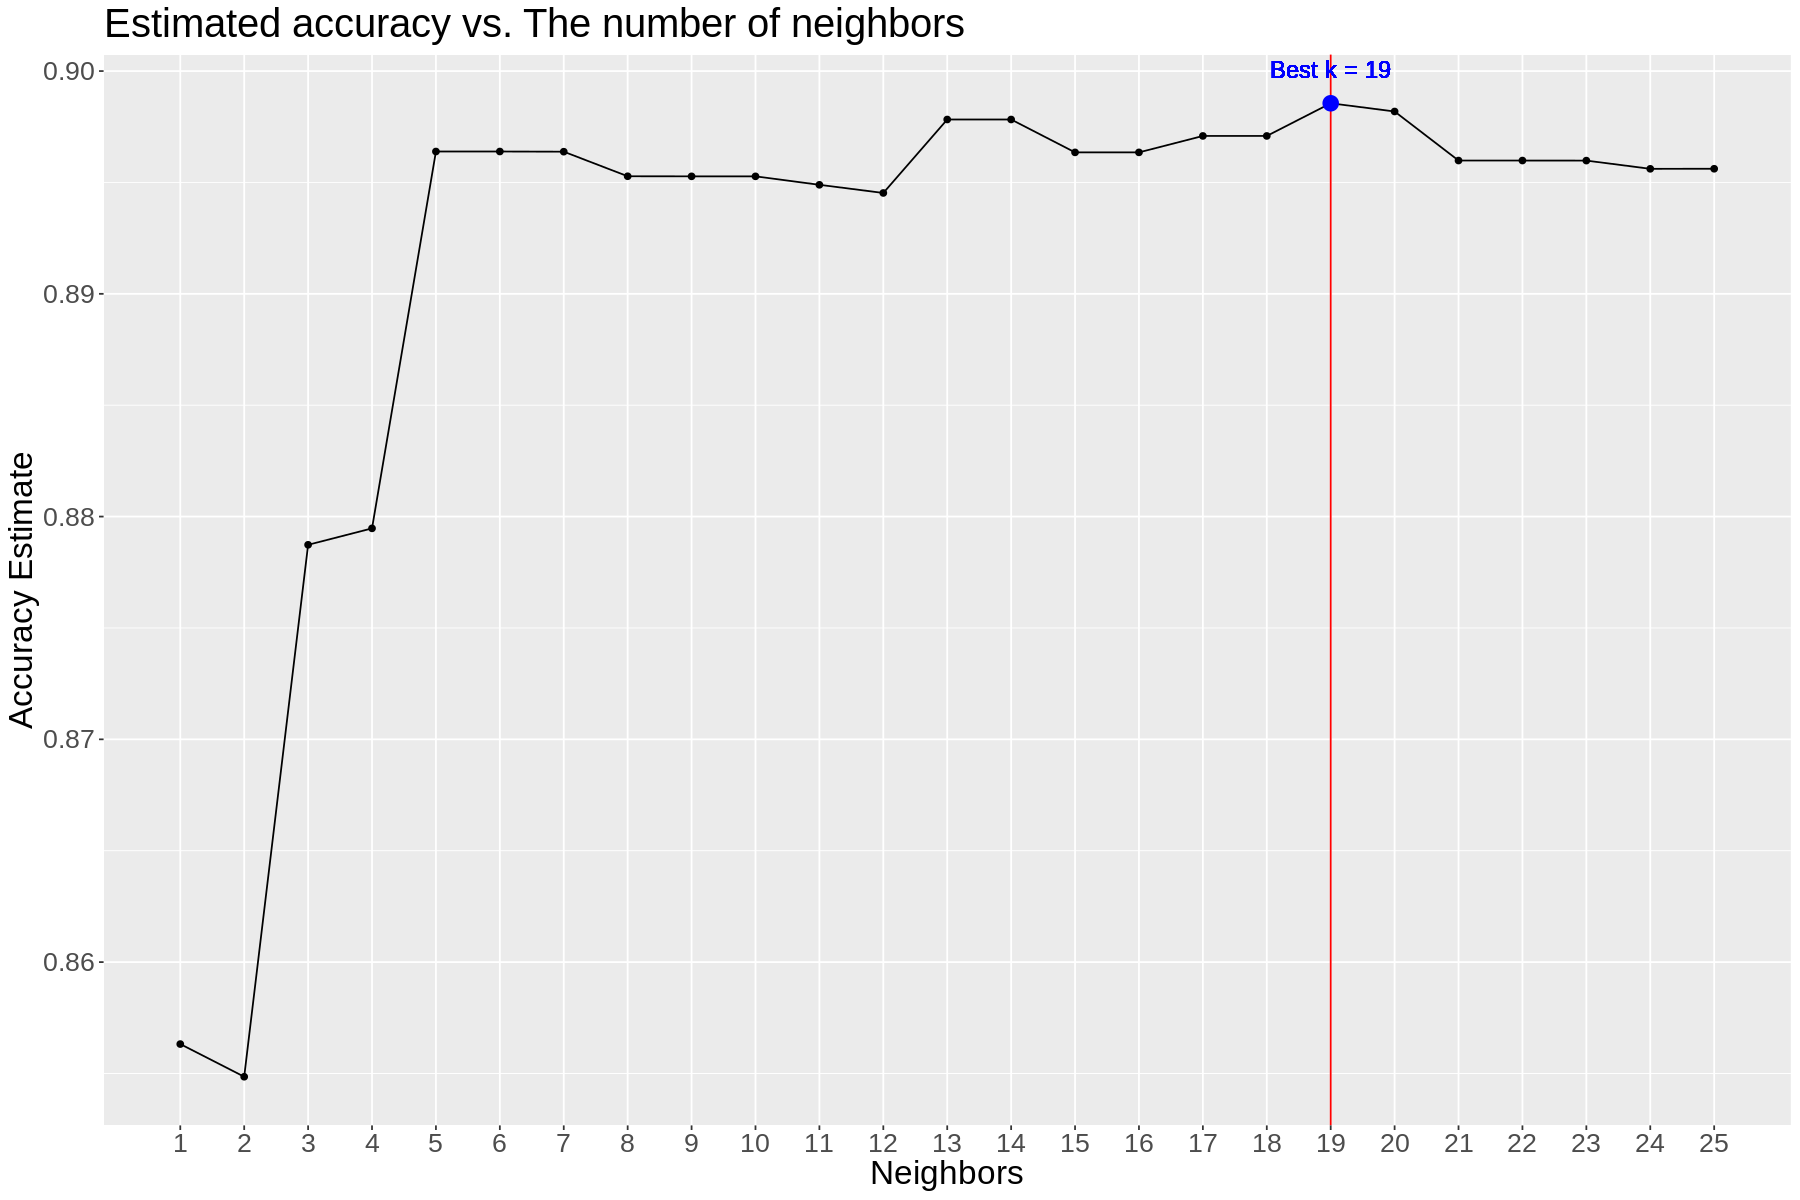

In [13]:
best_k <- students_results$neighbors[which.max(students_results$mean)]
max_accuracy <- max(students_results$mean)

options(repr.plot.width = 15, repr.plot.height = 10)

accuracy_vs_k <- students_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = best_k, color = "red") +
    geom_point(data = subset(students_results, neighbors == best_k), aes(x = neighbors, y = mean), size = 4, color = "blue") + 
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Estimated accuracy vs. The number of neighbors") + 
    geom_text(aes(x = best_k, y = max_accuracy, label = paste("Best k =", best_k)), 
            vjust = -1.5, color = "blue", size = 5) +
    scale_x_continuous(limits = c(1,25), breaks = seq(1,25), minor_breaks = seq(1,25,1)) +
    theme(text = element_text(size = 20))
accuracy_vs_k

In [14]:
#with the best k:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors =12) |>
    set_engine("kknn") |>
    set_mode("classification")

students_fit <- workflow() |>
    add_recipe(students_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = students_train )

In [15]:
#prediction:
students_predictions <- predict(students_fit , students_test) |> 
    bind_cols(students_test)

# Convert to factor
students_predictions$Target <- as.factor(students_predictions$Target)

# Compare the accuracy of predictions to the true values in the test set
students_acc <- students_predictions |> 
    metrics(truth = Target, estimate = .pred_class)  |>
    select(.metric, .estimate)|> 
    filter(.metric == "accuracy")
students_acc 

.metric,.estimate
<chr>,<dbl>
accuracy,0.8624862


In [ ]:
students_mat <- students_predictions |>
    conf_mat(truth = Target, estimate = .pred_class)

autoplot(students_mat, type = "heatmap") + 
    scale_fill_distiller(palette = "Set3", name = "Frequency") +
    theme(legend.position = "right", text = element_text(size = 20), plot.caption = element_text(size = 20, hjust = 0))

We first identify and select relevant variables from our dataset. These variables are chosen based on their perceived impact on academic success and dropout rates. We then apply an 75/25 train-test split to divide the data into a training set for model building and a test set for model evaluation. Using **KNN classification algorithm** chosen for its efficiency with large datasets and robustness against noisy data will help us predict the classification of new observations - students' academic statuses.

We use the mother's occupation as a visual representation. We construct a histogram featuring mother's occupation on the x-axis and the number of students on the y-axis. The distribution then is split into three plots based on the target variable, providing us with visual insights into the influence of mother's occupation on students' academic outcomes.

## 4. Discussion

We aim to examine the distribution of various factors in family background, students' performance indicators, as well as financial conditions. By doing so, we intend to identify the factors that significantly influence students' dropout rates and academic success statuses.

The results of this study can have a significant impact on educational institutions. Based on a review of the factors identified in the study on student academic outcomes, it can help administrators develop strategies that allow students from diverse backgrounds to improve their chances of success.

By understanding these factors, educational institutions can develop corresponding approaches to help current students improve the successful graduation rates. The future questions leading to our project could be how educational institutions can set up more practical policies on scholarship to help students with financial difficulties to finish their degree successfully.

## Reference
1. Realinho, V., Machado, J., Baptista, L., & Martins, M. V. (2022, October 28). Predicting Student Dropout and Academic Success. MDPI. https://doi.org/10.3390/data7110146
2. UCI Machine Learning Repository. (n.d.). https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
3. K-Nearest Neighbor in Machine Learning. (n.d.). https://www.knowledgehut.com/blog/data-science/knn-for-machine-learning